In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Experiment
ampl = np.array([[5188, 4571, 5012], 
                [4624, 4266, 4732], 
                [4571, 3631, 3758]])
phase = np.array([[0, 11, -30], 
                  [-12, 0, -30], [140, 0 ,0]])
phase0 = np.array([[23, 34, -7], 
                  [-12, 0, -30], [108, -112, -112]])
H_exp = ampl @ np.exp(-1j*phase0/57.3)
H_exp = np.dot(H_exp,np.matrix(H_exp, dtype=complex).H)
w, v = np.linalg.eig((H_exp))
np.round(np.log2(abs(w)))

array([29.,  2., 19.])

In [8]:
def dist(p1, p2):
    d = 0
    for i in range(len(p1)):
        d += (p1[i]-p2[i])**2
    return np.sqrt(d)
    
Pt = 19   # dBm
G = 5
fc = 5.6*10**9   # Hz
c = 3*10**8
lyam = c / fc
k = 2*np.pi / lyam
delta_d = 82 / 1000    # m
h = 2    # m
coordinates1 = [0.0, -delta_d, h]
coordinates2 = [3.0, -delta_d, h]
#print(dist(coordinates1, coordinates2) - dist([0.0, 0.0, h], [3.0, 2*delta_d, h]))


[[5553.70820598 4868.65251382 4584.75534754]
 [5239.85568532 5208.247201   3798.73180973]
 [3244.14720244 2734.59417157 3732.59765536]]
[[ -8.7517439  -10.4830265  -21.01026016]
 [-19.65910301   6.49687733 -17.71399673]
 [-19.68163304 -24.99412413 -21.9269315 ]]


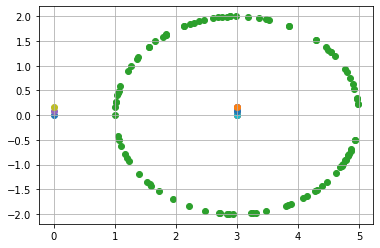

In [9]:
#  Stochastic 2D
d = dist(coordinates1, coordinates2)
w1 = np.zeros(3, dtype='complex')
H_list = [[0 for i in range(3)] for i2 in range(3)]
Hl = [[0, 0, 0],
     [0, 0, 0],
     [0, 0, 0]]
H_gbsm = np.array(H_list, dtype='complex')
K_rice = 3

N_size = 100
a_scat = -1 / np.sqrt(N_size*K_rice)
#r = np.random.exponential(scale=1.0, size = [1, N_size])+1.0
r = 2.0
azimuth = 2*np.pi*np.random.uniform(size = [1, N_size])
x_scat = r * np.cos(azimuth) +3.0
y_scat = r * np.sin(azimuth)
fig, ax = plt.subplots()

for i1 in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*i1  
    
    ax.scatter(coord1[0], coord1[1])
    for i2 in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*i2  
        
        ax.scatter(coord2[0], coord2[1])
        
        d1 = dist(coord1, coord2)
        ray1 = (1/d1) * np.exp(-1j*k*d1)
        rays = ray1
        for i in range(N_size):
            scat_coord = np.array([x_scat[0,i], y_scat[0,i], 0.0])
            dist_scat = dist(coord1, scat_coord) + dist(scat_coord, coord2)
            scat_ray = a_scat * (1/dist_scat)*np.exp(-1j*k*dist_scat)
            rays += scat_ray
        a_ampl = (lyam/4/np.pi) * rays 
        ph2 = -1*np.arctan2(np.imag(a_ampl), np.real(a_ampl))

        a_db = 20*np.log10(np.abs(a_ampl)) + G
        snr_db = a_db + 119 + 5.1
        snr = 10**(snr_db/20)
        H_gbsm[2-i1, 2-i2] = snr*np.exp(1j*ph2)
print(abs(H_gbsm))
print(-57.3*np.arctan2(np.imag(H_gbsm), np.real(H_gbsm)))

#fig, ax = plt.subplots()
ax.scatter(x_scat, y_scat)

plt.grid()
plt.savefig("a2.jpg")
plt.show()

In [10]:
# (New) Ray-based model
H_list = [[0 for i in range(3)] for i2 in range(3)]
H = np.array(H_list, dtype='complex')
#a_scat = -0.5
K_rice = 3
a_scat = -1 / np.sqrt(3*K_rice)
for i in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*(i - 1)    
    for i2 in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*(i2 - 1)
        
        dist1 = dist(coord1, coord2)
        ray1 = (1/dist1) * np.exp(-1j*k*dist1)
        
        coord12 = list(coord1)
        coord12[1] = -(coord1[1] + 4)
        dist2 = dist(coord12, coord2)
        ray2 = a_scat*(1/dist2) * np.exp(-1j*k*dist2)
        
        coord13 = list(coord1)
        coord13[0] = -(coord1[0] + 6.2)
        dist3 = dist(coord13, coord2)
        ray3 = a_scat*(1/dist3) * np.exp(-1j*k*dist3)

        coord14 = list(coord1)
        coord14[2] = -coord1[2]
        dist4 = dist(coord14, coord2)
        ray4 = a_scat*(1/dist4) * np.exp(-1j*k*dist4)
        
        a_ampl = (lyam/4/np.pi) * (ray1 + ray2 + ray3 + ray4)
        ph2 = -1*np.arctan2(np.imag(a_ampl), np.real(a_ampl))

        a_db = 20*np.log10(np.abs(a_ampl)) + G
        snr_db = a_db + 119 + 5.1
        snr = 10**(snr_db/20)
        H[2-i, 2-i2] = snr*np.exp(1j*ph2)
#w = np.linalg.eigvals((H@H))
#np.round(np.log2(abs(w)))
print(-57.3*np.arctan2(np.imag(H), np.real(H)))
abs(H)

[[ -6.52431206  -6.61725316 -15.30377546]
 [ -6.61725316  11.13043149   3.45141274]
 [-15.30377546   3.45141274  -3.19408051]]


array([[4286.30472896, 5275.59754728, 4642.66156417],
       [5275.59754728, 5001.74473109, 3886.96160692],
       [4642.66156417, 3886.96160692, 3826.85505455]])

In [14]:
# Free-space calculations
offset = 0.0
H_list = [[0 for i in range(3)] for i2 in range(3)]

H2 = np.array(H_list, dtype='complex')
for i in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*i    
    for i2 in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*i2

        d1 = dist(coord1, coord2)
        line1 = (1/d1) * np.exp(-1j*k*d1)
        l1 = 1/d1
        coord2_inv = list(coord2)
        coord2_inv[2] = -coord2_inv[2]
        d2 = dist(coord1, coord2_inv)
        line2 = (1/d2) * np.exp(-1j*k*d2)
        a_ampl = (lyam/4/np.pi) * (line1)
        ph2 = -1*np.arctan2(np.imag(a_ampl), np.real(a_ampl))

        a_db = 20*np.log10(np.abs(a_ampl)) + G
        #a1  = (4*np.pi*d1/lyam)**2
        snr_db = a_db + 119 + 5.1
        #print(a_db)
        snr = 10**(snr_db/20)
        #print(snr)
        H2[i, i2] = snr*np.exp(1j*ph2)
#H2_sq = np.dot(H2,np.matrix(H2, dtype=complex).H)
#w2 = np.linalg.eigvals((H2_sq))
#np.round(np.log2(abs(w2)))
abs(H2)

array([[4051.37187606, 4049.85931107, 4045.33176072],
       [4049.85931107, 4051.37187606, 4049.85931107],
       [4045.33176072, 4049.85931107, 4051.37187606]])

In [18]:
# Fading
K_rice = 3
H_fading = np.zeros([3, 3], dtype = 'complex')
N_fading_times = 1
for n in range(N_fading_times):
    H_NLOS = H2 @ (np.random.randn(3,3)+1j*np.random.randn(3,3))*np.sqrt(1/2/(K_rice+1))
    H_LOS = H2 * np.sqrt(K_rice/(K_rice+1))
    H_fad_tmp = H_NLOS + H_LOS
    H_fading += H_fad_tmp
H_fading /= N_fading_times
#H2_sq = np.dot(H_fading,np.matrix(H_fading, dtype=complex).H)
#w2 = np.linalg.eigvals((H2_sq))
#np.round(np.log2(abs(w2)))
print(-57.3*np.arctan2(np.imag(H_fading), np.real(H_fading)))
abs(H_fading)

[[ 10.18456839  -0.2042066  -47.10837185]
 [  2.84338675   9.65019965 -29.5920031 ]
 [-18.79742149   4.53454357 -28.411402  ]]


array([[4604.58250836, 5791.1429794 , 3510.48931464],
       [4641.53004351, 6387.1792565 , 3683.44988726],
       [4753.66851219, 6732.68088295, 3647.75303612]])

In [19]:
from scipy.linalg import fractional_matrix_power

Rr = np.array([[1.0, 0.6, 0.4], [0.6, 1.0, 0.6], [0.4, 0.6, 1.0]])
#Rt = np.array([[1.0, 0.6, 0.4], [0.6, 1.0, 0.6], [0.4, 0.6, 1.0]])
Rt = np.array(Rr)

Rr_half = fractional_matrix_power(Rr, 0.5)
Rt_half = fractional_matrix_power(Rt, 0.5)
Rt_half_H = np.conj(Rt_half).T
#print(Rr_half)

#H_kron = np.dot(np.dot(H_fading, Rt_half_H), Rt_half_H)
Hw = H_fading / np.max(H2)
H_kron = np.dot(Rr_half, np.dot(Hw, Rt_half_H))
coef = np.max(np.sum(H_fading) / np.max(np.sum(H_kron)))
#print(coef)
print(-57.3*np.arctan2(np.imag(H_kron), np.real(H_kron)))
abs(H_kron*coef)

[[  0.77838781  -2.38118826 -21.8655661 ]
 [ -0.88514093   0.68091171 -16.36398326]
 [ -8.14192677  -2.01202388 -16.96304914]]


array([[4390.32255874, 5128.01205207, 3665.35123055],
       [4831.52132695, 5755.5895521 , 4133.71236498],
       [4577.49064987, 5525.0002811 , 3960.75187356]])

In [20]:
# ITUR 1238
N = 30
log_f = 20*np.log10(fc*10**-6)
for i in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*i    
    for j in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*j
        d = dist(coord1, coord2)
        L_itur = log_f + N*np.log10(d) - 28
        snr_itur = Pt - L_itur + 100 + 16
        snr = 10**(snr_itur/20)
        print(snr)

4854.338878740481
4851.620607794256
4843.48705997248
4851.620607794256
4854.338878740481
4851.620607794256
4843.48705997248
4851.620607794256
4854.338878740481


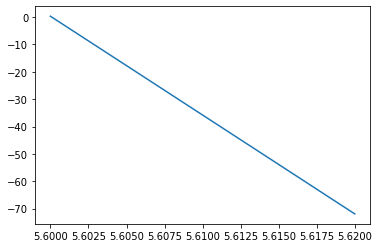

In [133]:
# Phase response
freq_lin = np.linspace(5.6, 5.62, 100)
c = 3*10**8
lam_lin = c / freq_lin / 10**9
k_lin = 2*np.pi / lam_lin
d1 = dist(coordinates1, coordinates2)
coord2_inv = list(coordinates2)
coord2_inv[2] = -coord2_inv[2]
d2 = dist(coordinates1, coord2_inv)


line1 = (1/d1) * np.exp(-1j*k_lin*d1)
line2 = (1/d2) * np.exp(-1j*k_lin*d2)
a = (lam_lin/4/np.pi) * (line1 - 0.01*line2)
phase = np.arctan2(np.imag(a), np.real(a))*57.3
#print(d2)
plt.plot(freq_lin, phase)
plt.show()

In [43]:
H1 = [[-47.5*np.exp(-1.95j), -45.7*np.exp(0.52j), -45.0*np.exp(-0.12j)],
     [-47.8*np.exp(-1.95j), -46.3*np.exp(0.0j), -45.8*np.exp(0.59j)],
     [-45.7*np.exp(1.87j), -45.7*np.exp(-0.21j), -44.7*np.exp(0.4j)]]
H1 = np.array(H1, dtype = 'complex')
H1_tm = 10**((-abs(H1) + 119)/20)
H1_tm

array([[3758.37404288, 4623.81021399, 5011.87233627],
       [3630.7805477 , 4315.19076828, 4570.88189615],
       [4623.81021399, 4623.81021399, 5188.00038929]])

In [16]:
H1 = np.array(H1)
H = -1*abs(H1)
for i in range(3):
    for j in range(3):
        a = H[i][j] + 119
        b = 10**(a/20)
        print(b)

3758.374042884443
4623.810213992608
5011.872336272725
3630.780547701021
4315.190768277655
4570.881896148751
4623.810213992603
4623.810213992603
5188.000389289609


In [76]:
A = np.array([[1, 1], [1, 0], [0, 1]])
eig = np.linalg.svd(A)
eig

(array([[-8.16496581e-01,  1.85577521e-16, -5.77350269e-01],
        [-4.08248290e-01, -7.07106781e-01,  5.77350269e-01],
        [-4.08248290e-01,  7.07106781e-01,  5.77350269e-01]]),
 array([1.73205081, 1.        ]),
 array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))